In [2]:
import pandas as pd

df = pd.read_csv('data_sorted.csv')
df.head()

,success,actual_time,optimal_time,goal_x,goal_y,world_idx,lidar_0,lidar_1,lidar_2,lidar_3,...,lidar_718,lidar_719,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular,timestep
0,True,16.639,6.796149,0.0,10.0,0,2.975059,2.950377,2.938696,2.933910,...,2.950528,2.976332,-0.000009,0.000073,1.570909,0.000043,0.008641,0.006,0.000665,0
1,True,16.639,6.796149,0.0,10.0,0,2.975632,2.949891,2.938163,2.934393,...,2.949972,2.976789,-0.000009,0.000073,1.570903,0.000043,0.003630,0.012,0.001330,1
2,True,16.639,6.796149,0.0,10.0,0,2.974015,2.950373,2.940136,2.935323,...,2.951352,2.975511,-0.000009,0.000193,1.570919,0.003106,0.004454,0.018,0.001996,2
3,True,16.639,6.796149,0.0,10.0,0,2.972146,2.951025,2.939157,2.935039,...,2.950131,2.976381,-0.000009,0.000432,1.570933,0.007701,0.001190,0.024,0.002661,3
4,True,16.639,6.796149,0.0,10.0,0,2.974818,2.951458,2.940485,2.935588,...,2.950873,2.976459,-0.000009,0.000792,1.570969,0.013069,0.005987,0.030,0.003326,4


In [3]:
df.describe()

,actual_time,optimal_time,goal_x,goal_y,world_idx,lidar_0,lidar_1,lidar_2,lidar_3,lidar_4,...,lidar_718,lidar_719,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular,timestep
count,202569.000000,202569.000000,202569.0,202569.0,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,...,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000
mean,12.902522,5.715869,0.0,10.0,151.958370,4.115800,4.135718,4.152697,4.171695,4.190318,...,4.341831,4.328646,-0.040379,4.130155,1.548915,0.704698,-0.003710,0.705616,-0.002722,343.772685
std,2.451819,0.375246,0.0,0.0,87.229118,6.490961,6.553439,6.610645,6.670345,6.728279,...,7.042407,6.992671,0.530169,2.789321,0.385390,0.211738,0.259670,0.208302,0.233824,210.896994
min,11.784000,5.026614,0.0,10.0,0.000000,0.292403,0.291040,0.289275,0.287048,0.286279,...,0.292182,0.293237,-1.714366,-0.000258,-3.141397,-0.337823,-2.126267,-0.300000,-1.570796,0.000000
25%,11.937000,5.446358,0.0,10.0,76.000000,1.691495,1.684698,1.677570,1.671675,1.666527,...,1.601476,1.608613,-0.308475,1.634119,1.465763,0.799501,-0.062289,0.800000,-0.067353,168.000000
50%,12.136000,5.617254,0.0,10.0,153.000000,2.879177,2.865790,2.851509,2.837667,2.824436,...,2.823026,2.836414,-0.006654,4.026890,1.578731,0.800233,-0.001211,0.800000,0.000042,337.000000
75%,12.518000,5.922971,0.0,10.0,228.000000,3.195433,3.179926,3.163331,3.149627,3.134901,...,3.162534,3.180164,0.208518,6.519710,1.678931,0.801077,0.044440,0.800000,0.052444,506.000000
max,26.686000,6.867653,0.0,10.0,299.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,1.653924,9.367064,3.140065,0.811978,2.186863,0.800000,1.570796,1375.000000


In [7]:
# torch Dataset
from torch.utils.data import Dataset
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class KULBarnDataset(Dataset):
    def get_local_goal(self):
        x = self.data['pos_x']
        y = self.data['pos_y']
        theta = self.data['pose_heading']
        goal_x = self.data['goal_x']
        goal_y = self.data['goal_y']
        self.data['local_x'] = (goal_x - x) * np.cos(theta) + (goal_y - y) * np.sin(theta)
        self.data['local_y'] = -(goal_x - x) * np.sin(theta) + (goal_y - y) * np.cos(theta)
    
    def __init__(self, df, scaler=None):
        super().__init__()

        self.data = df
        self.get_local_goal()   
        self.data = self.data.drop(columns=[
            'world_idx', 'timestep', 'actual_time', 'optimal_time', 
            'pos_x', 'pos_y', 'pose_heading', 'goal_x', 'goal_y', 'success'
        ])

        if scaler is None:
            self.scaler = MinMaxScaler()
            self.scaler.fit(self.data)
        else:
            self.scaler = scaler
        self.data = pd.DataFrame(self.scaler.transform(self.data), columns=self.data.columns)
        
        # get all the column values that contain the word lidar
        self.lidar_cols = [col for col in self.data.columns if 'lidar' in col]
        # get actions columns
        self.actions_cols = [col for col in self.data.columns if 'cmd' in col]
        # get other columns
        self.non_lidar_cols = [col for col in self.data.columns if col not in self.lidar_cols and col not in self.actions_cols]
        print("Lidar Columns:", self.lidar_cols)
        print("Non Lidar Columns:", self.non_lidar_cols)
        print("Action Columns:", self.actions_cols)

        self.lidar_data = self.data[self.lidar_cols].values
        self.non_lidar_data = self.data[self.non_lidar_cols].values
        self.actions_data = self.data[self.actions_cols].values

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        lidar = self.lidar_data[idx]
        non_lidar = self.non_lidar_data[idx]
        actions = self.actions_data[idx]
        return lidar, non_lidar, actions

In [8]:
# split train and test
import random

NO_WORLDS = 300
TRAIN_RATIO = 0.8
world_ids = [i for i in range(NO_WORLDS)]
# select 0.8 of the world_ids as train_ids randomized
train_ids = random.sample(world_ids, int(NO_WORLDS * TRAIN_RATIO))
test_ids = [id for id in world_ids if id not in train_ids]

train_df = df[df['world_idx'].isin(train_ids)]
test_df = df[df['world_idx'].isin(test_ids)]

In [9]:
train_dataset = KULBarnDataset(train_df)
scaler = train_dataset.scaler
test_dataset = KULBarnDataset(test_df, scaler)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

/home/jvthunder/anaconda/envs/mimic_data_extraction/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/jvthunder/anaconda/envs/mimic_data_extraction/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Lidar Columns: ['lidar_0', 'lidar_1', 'lidar_2', 'lidar_3', 'lidar_4', 'lidar_5', 'lidar_6', 'lidar_7', 'lidar_8', 'lidar_9', 'lidar_10', 'lidar_11', 'lidar_12', 'lidar_13', 'lidar_14', 'lidar_15', 'lidar_16', 'lidar_17', 'lidar_18', 'lidar_19', 'lidar_20', 'lidar_21', 'lidar_22', 'lidar_23', 'lidar_24', 'lidar_25', 'lidar_26', 'lidar_27', 'lidar_28', 'lidar_29', 'lidar_30', 'lidar_31', 'lidar_32', 'lidar_33', 'lidar_34', 'lidar_35', 'lidar_36', 'lidar_37', 'lidar_38', 'lidar_39', 'lidar_40', 'lidar_41', 'lidar_42', 'lidar_43', 'lidar_44', 'lidar_45', 'lidar_46', 'lidar_47', 'lidar_48', 'lidar_49', 'lidar_50', 'lidar_51', 'lidar_52', 'lidar_53', 'lidar_54', 'lidar_55', 'lidar_56', 'lidar_57', 'lidar_58', 'lidar_59', 'lidar_60', 'lidar_61', 'lidar_62', 'lidar_63', 'lidar_64', 'lidar_65', 'lidar_66', 'lidar_67', 'lidar_68', 'lidar_69', 'lidar_70', 'lidar_71', 'lidar_72', 'lidar_73', 'lidar_74', 'lidar_75', 'lidar_76', 'lidar_77', 'lidar_78', 'lidar_79', 'lidar_80', 'lidar_81', 'lidar_82'

/home/jvthunder/anaconda/envs/mimic_data_extraction/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/jvthunder/anaconda/envs/mimic_data_extraction/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Lidar Columns: ['lidar_0', 'lidar_1', 'lidar_2', 'lidar_3', 'lidar_4', 'lidar_5', 'lidar_6', 'lidar_7', 'lidar_8', 'lidar_9', 'lidar_10', 'lidar_11', 'lidar_12', 'lidar_13', 'lidar_14', 'lidar_15', 'lidar_16', 'lidar_17', 'lidar_18', 'lidar_19', 'lidar_20', 'lidar_21', 'lidar_22', 'lidar_23', 'lidar_24', 'lidar_25', 'lidar_26', 'lidar_27', 'lidar_28', 'lidar_29', 'lidar_30', 'lidar_31', 'lidar_32', 'lidar_33', 'lidar_34', 'lidar_35', 'lidar_36', 'lidar_37', 'lidar_38', 'lidar_39', 'lidar_40', 'lidar_41', 'lidar_42', 'lidar_43', 'lidar_44', 'lidar_45', 'lidar_46', 'lidar_47', 'lidar_48', 'lidar_49', 'lidar_50', 'lidar_51', 'lidar_52', 'lidar_53', 'lidar_54', 'lidar_55', 'lidar_56', 'lidar_57', 'lidar_58', 'lidar_59', 'lidar_60', 'lidar_61', 'lidar_62', 'lidar_63', 'lidar_64', 'lidar_65', 'lidar_66', 'lidar_67', 'lidar_68', 'lidar_69', 'lidar_70', 'lidar_71', 'lidar_72', 'lidar_73', 'lidar_74', 'lidar_75', 'lidar_76', 'lidar_77', 'lidar_78', 'lidar_79', 'lidar_80', 'lidar_81', 'lidar_82'

In [10]:
# dataloader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# test dataloader
lidar, non_lidar, actions = next(iter(train_loader))
print(f"Non lidar shape: {non_lidar.shape}")
print(f"Lidar shape: {lidar.shape}")
# print size dataloader
print(f"Train loader size: {len(train_loader)}")
print(f"Test loader size: {len(test_loader)}")
print(lidar, non_lidar, actions)

Non lidar shape: torch.Size([32, 4])
Lidar shape: torch.Size([32, 720])
Train loader size: 5075
Test loader size: 1256
tensor([[0.0945, 0.0944, 0.0945,  ..., 0.0835, 0.0839, 0.0850],
        [0.0543, 0.0240, 0.0235,  ..., 0.0109, 0.0107, 0.0106],
        [0.0241, 0.0241, 0.0241,  ..., 0.1310, 0.1340, 0.1340],
        ...,
        [0.0148, 0.0147, 0.0146,  ..., 0.1703, 0.1735, 0.0211],
        [0.0105, 0.0106, 0.0107,  ..., 0.0136, 0.0138, 0.0139],
        [0.0685, 0.0683, 0.0681,  ..., 0.0960, 0.0960, 0.0962]],
       dtype=torch.float64) tensor([[0.9897, 0.4781, 0.4917, 0.4889],
        [0.9909, 0.4888, 0.7729, 0.3028],
        [0.9892, 0.4912, 0.5896, 0.5045],
        [0.9904, 0.4932, 0.6825, 0.5969],
        [0.9893, 0.5043, 0.5418, 0.4999],
        [0.9898, 0.4898, 0.5994, 0.4776],
        [0.9937, 0.4622, 0.8473, 0.3265],
        [0.9934, 0.5253, 0.8687, 0.3573],
        [0.3520, 0.4935, 0.9995, 0.4956],
        [0.4522, 0.5095, 0.9964, 0.4888],
        [0.9891, 0.4922, 0.4967, 0.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_lidar_features, num_non_lidar_features, num_actions, nframes=1):
        super(CNNModel, self).__init__()
        self.act_fea_cv1 = nn.Conv1d(
            in_channels=nframes, out_channels=32, kernel_size=5, stride=2, padding=6, padding_mode='circular'
        )
        self.act_fea_cv2 = nn.Conv1d(
            in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1
        )

        conv_output_size = (num_lidar_features - 5 + 2*6) // 2 + 1  # Output size after self.act_fea_cv1
        conv_output_size = (conv_output_size - 3 + 2*1) // 2 + 1  # Output size after self.act_fea_cv2
        conv_output_size *= 32  # Multiply by the number of output channels

        # Calculate the output size of the CNN
        self.fc1 = nn.Linear(conv_output_size, 32)
        self.fc2 = nn.Linear(32 + num_non_lidar_features, num_actions)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, lidar, non_lidar):
        lidar = lidar.unsqueeze(1)  # Add channel dimension
        feat = F.relu(self.act_fea_cv1(lidar))
        feat = F.relu(self.act_fea_cv2(feat))
        feat = feat.view(feat.shape[0], -1)
        feat = F.relu(self.fc1(feat))
        feat = torch.cat((feat, non_lidar), dim=-1)
        feat = F.relu(self.fc2(feat))
        return feat

In [8]:
# Initialize the model
num_lidar_features = train_dataset.lidar_data.shape[-1]
num_non_lidar_features = train_dataset.non_lidar_data.shape[-1]
num_actions = train_dataset.actions_data.shape[-1]
model = CNNModel(num_lidar_features, num_non_lidar_features, num_actions)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cpu


In [9]:
from tqdm import tqdm

def train_model(model, train_loader, loss_fn, optimizer):
    model.train()

    losses = []
    for lidar, non_lidar, actions in tqdm(train_loader):

        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [10]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions in tqdm(test_loader):
        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [11]:
import sys
NUM_EPOCHS = 30

random_test_loss = test_model(model, test_loader, loss_fn)
print("Random test loss:", random_test_loss)
sys.stdout.flush()

cnn_train_losses = []
cnn_test_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    test_loss = test_model(model, test_loader, loss_fn)
    cnn_train_losses.append(train_loss)
    cnn_test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Test Loss: {test_loss}")
    sys.stdout.flush()

100%|██████████| 1275/1275 [00:01<00:00, 676.09it/s]

Random test loss: 0.43058515689536636



100%|██████████| 1275/1275 [00:01<00:00, 947.52it/s]

Epoch 1/20 | Train Loss: 0.0071082670326718415 | Test Loss: 0.005424800574307001



100%|██████████| 1275/1275 [00:01<00:00, 995.46it/s] 

Epoch 2/20 | Train Loss: 0.003829534158331292 | Test Loss: 0.0034269194084488703



100%|██████████| 1275/1275 [00:01<00:00, 1034.01it/s]

Epoch 3/20 | Train Loss: 0.002501455972712473 | Test Loss: 0.002490716436124571



100%|██████████| 1275/1275 [00:01<00:00, 933.87it/s]

Epoch 4/20 | Train Loss: 0.0018244826526629195 | Test Loss: 0.0018442465762949294



100%|██████████| 1275/1275 [00:01<00:00, 936.06it/s]

Epoch 5/20 | Train Loss: 0.0014498060943913492 | Test Loss: 0.0014887486290771287



100%|██████████| 1275/1275 [00:01<00:00, 999.37it/s] 

Epoch 6/20 | Train Loss: 0.0012113275576488192 | Test Loss: 0.0012233272784464599



100%|██████████| 1275/1275 [00:01<00:00, 968.26it/s] 

Epoch 7/20 | Train Loss: 0.0010525569721569154 | Test Loss: 0.0010638477407519532



100%|██████████| 1275/1275 [00:01<00:00, 989.08it/s]

Epoch 8/20 | Train Loss: 0.0009460419400779123 | Test Loss: 0.0009027681313433705



100%|██████████| 1275/1275 [00:01<00:00, 936.86it/s]

Epoch 9/20 | Train Loss: 0.0008723513213534359 | Test Loss: 0.000832044693685805



100%|██████████| 1275/1275 [00:01<00:00, 1007.41it/s]

Epoch 10/20 | Train Loss: 0.0008174916425297875 | Test Loss: 0.0008361748582416005



100%|██████████| 1275/1275 [00:01<00:00, 949.33it/s]

Epoch 11/20 | Train Loss: 0.0007758747470959377 | Test Loss: 0.0007911761748280197



100%|██████████| 1275/1275 [00:01<00:00, 1026.81it/s]

Epoch 12/20 | Train Loss: 0.0007415008119112285 | Test Loss: 0.0007887012170695194



100%|██████████| 1275/1275 [00:01<00:00, 952.40it/s]

Epoch 13/20 | Train Loss: 0.0007133462652514257 | Test Loss: 0.0007643331389920372



100%|██████████| 1275/1275 [00:01<00:00, 1000.08it/s]

Epoch 14/20 | Train Loss: 0.0006906872896594525 | Test Loss: 0.0007998740363483889



100%|██████████| 1275/1275 [00:01<00:00, 1015.81it/s]

Epoch 15/20 | Train Loss: 0.0006661654017980715 | Test Loss: 0.0007716202021353692



100%|██████████| 1275/1275 [00:01<00:00, 1003.05it/s]

Epoch 16/20 | Train Loss: 0.0006460575072249908 | Test Loss: 0.0007604940933197213



100%|██████████| 1275/1275 [00:01<00:00, 1023.84it/s]

Epoch 17/20 | Train Loss: 0.0006250874018371201 | Test Loss: 0.0007922144024024758



100%|██████████| 1275/1275 [00:01<00:00, 957.81it/s]

Epoch 18/20 | Train Loss: 0.0006060490175635015 | Test Loss: 0.0008070387633583153



100%|██████████| 1275/1275 [00:01<00:00, 970.67it/s]

Epoch 19/20 | Train Loss: 0.0005875516102219944 | Test Loss: 0.0007659331871284438



100%|██████████| 1275/1275 [00:01<00:00, 1017.69it/s]

Epoch 20/20 | Train Loss: 0.0005715507166878035 | Test Loss: 0.0007942585749402925


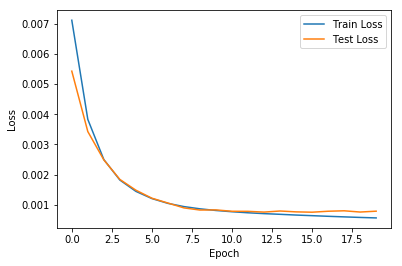

In [19]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [13]:
# save the model
torch.save(model.state_dict(), 'model/cnn_model.pth')

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

class TransformerModel(nn.Module):
    def __init__(self, num_lidar_features, num_non_lidar_features, num_actions, d_model=64, nhead=8, num_encoder_layers=3, num_decoder_layers=3):
        super(TransformerModel, self).__init__()

        self.d_model = d_model
        self.num_patches = 20  # Number of patches
        self.patch_size = num_lidar_features // self.num_patches

        # Positional Encoding for the Encoder
        self.positional_encoding = nn.Parameter(torch.zeros(self.num_patches, d_model))

        # Input Embedding for Encoder (LiDAR data)
        self.lidar_embedding = nn.Linear(self.patch_size, d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Input Embedding for Decoder (Non-LiDAR data)
        self.non_lidar_embedding = nn.Linear(num_non_lidar_features, d_model)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Linear layer to map the transformer output to actions
        self.fc_out = nn.Linear(d_model, num_actions)

    def forward(self, lidar, non_lidar):
        batch_size = lidar.size(0)
        
        # Divide LiDAR input into patches
        lidar_patches = lidar.view(batch_size, self.num_patches, self.patch_size)

        # Embed each patch and add positional encoding
        lidar_embed = self.lidar_embedding(lidar_patches) + self.positional_encoding.unsqueeze(0)
        lidar_embed = lidar_embed.permute(1, 0, 2)  # Convert to (seq_len, batch_size, d_model)

        # Process through the transformer encoder
        memory = self.transformer_encoder(lidar_embed)

        # Process non-lidar data through input embedding
        non_lidar_embed = self.non_lidar_embedding(non_lidar).unsqueeze(0)  # Convert to (1, batch_size, d_model)

        # Process through the transformer decoder
        output = self.transformer_decoder(non_lidar_embed, memory)

        # Final linear layer to get the actions
        actions = self.fc_out(output.squeeze(0))
        return actions

In [15]:
# Initialize the model
num_lidar_features = train_dataset.lidar_data.shape[1]
num_non_lidar_features = train_dataset.non_lidar_data.shape[1]
num_actions = train_dataset.actions_data.shape[1]
model = TransformerModel(num_lidar_features, num_non_lidar_features, num_actions)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cpu


In [16]:
import sys
NUM_EPOCHS = 30

random_test_loss = test_model(model, test_loader, loss_fn)
print("Random test loss:", random_test_loss)

transformer_train_losses = []
transformer_test_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    test_loss = test_model(model, test_loader, loss_fn)
    transformer_train_losses.append(train_loss)
    transformer_test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Test Loss: {test_loss}")
    sys.stdout.flush()

  0%|          | 3/5056 [00:00<03:21, 25.02it/s]

Random test loss: 0.3762618096727951


100%|██████████| 1275/1275 [00:12<00:00, 104.81it/s]

Epoch 1/20 | Train Loss: 0.003284222281746236 | Test Loss: 0.0008301055286018014



100%|██████████| 1275/1275 [00:12<00:00, 104.26it/s]

Epoch 2/20 | Train Loss: 0.0013285176123789123 | Test Loss: 0.0008079318579706631



100%|██████████| 1275/1275 [00:12<00:00, 96.59it/s] 

Epoch 3/20 | Train Loss: 0.0011207993986930933 | Test Loss: 0.000681142465275615



100%|██████████| 1275/1275 [00:12<00:00, 105.45it/s]

Epoch 4/20 | Train Loss: 0.0010232373985782264 | Test Loss: 0.0008376198952992483



100%|██████████| 1275/1275 [00:12<00:00, 103.45it/s]

Epoch 5/20 | Train Loss: 0.0009674647776778962 | Test Loss: 0.0007036111668197669



100%|██████████| 1275/1275 [00:12<00:00, 103.45it/s]

Epoch 6/20 | Train Loss: 0.000928592813162267 | Test Loss: 0.0006119778279575186



100%|██████████| 1275/1275 [00:12<00:00, 105.27it/s]

Epoch 7/20 | Train Loss: 0.0009040619715831413 | Test Loss: 0.0005864994467329406



100%|██████████| 1275/1275 [00:12<00:00, 98.90it/s] 

Epoch 8/20 | Train Loss: 0.0008838334872313128 | Test Loss: 0.0006119868147609796



100%|██████████| 1275/1275 [00:12<00:00, 99.97it/s] 

Epoch 9/20 | Train Loss: 0.0008660410143646384 | Test Loss: 0.0006530270835997619



100%|██████████| 1275/1275 [00:12<00:00, 99.71it/s] 

Epoch 10/20 | Train Loss: 0.00084255134344377 | Test Loss: 0.0006086919977074371



100%|██████████| 1275/1275 [00:12<00:00, 98.23it/s] 

Epoch 11/20 | Train Loss: 0.0008217170759018723 | Test Loss: 0.0006207736164929777



100%|██████████| 1275/1275 [00:12<00:00, 98.18it/s] 

Epoch 12/20 | Train Loss: 0.0008049223797469713 | Test Loss: 0.00058691231376373



100%|██████████| 1275/1275 [00:12<00:00, 98.36it/s] 

Epoch 13/20 | Train Loss: 0.00078051152918752 | Test Loss: 0.000609815698162002



100%|██████████| 1275/1275 [00:13<00:00, 97.69it/s] 

Epoch 14/20 | Train Loss: 0.0007575560883368135 | Test Loss: 0.0005985311144730291



100%|██████████| 1275/1275 [00:13<00:00, 97.71it/s] 

Epoch 15/20 | Train Loss: 0.0007433276450068275 | Test Loss: 0.0006479093604288851



100%|██████████| 1275/1275 [00:12<00:00, 103.13it/s]

Epoch 16/20 | Train Loss: 0.0007231641115805371 | Test Loss: 0.0006132599732181381



100%|██████████| 1275/1275 [00:12<00:00, 99.93it/s] 

Epoch 17/20 | Train Loss: 0.0007082176005437875 | Test Loss: 0.0006510917796257156



100%|██████████| 1275/1275 [00:12<00:00, 98.54it/s] 

Epoch 18/20 | Train Loss: 0.0006884012412443335 | Test Loss: 0.0006403043900994745



100%|██████████| 1275/1275 [00:12<00:00, 98.94it/s] 

Epoch 19/20 | Train Loss: 0.0006800927516979478 | Test Loss: 0.0006269295270723496



100%|██████████| 1275/1275 [00:12<00:00, 99.58it/s] 

Epoch 20/20 | Train Loss: 0.0006708217036563401 | Test Loss: 0.0006495781198188578


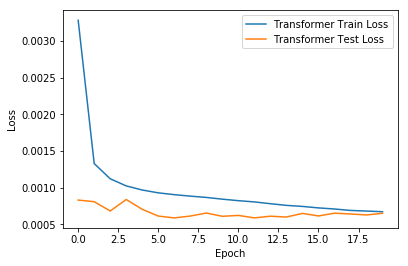

In [17]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(transformer_train_losses, label='Transformer Train Loss')
plt.plot(transformer_test_losses, label='Transformer Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [18]:
# save the model
torch.save(model.state_dict(), 'model/transformer_model.pth')